# Resnet Model

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import time
import copy
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Importing Data

In [3]:
base_dir = os.getcwd()

In [4]:
data_dir = os.path.join(base_dir, 'data')
output_dir = os.path.join(base_dir, 'outputs')
processed_data_dir = os.path.join(base_dir, 'processed_data')
files = listdir(data_dir)

print(len(files))

280


In [5]:
train_file_path = os.path.join(processed_data_dir, 'train_df.pkl')
test_file_path =  os.path.join(processed_data_dir, 'test_df.pkl')
dev_file_path =  os.path.join(processed_data_dir, 'dev_df.pkl')


In [6]:
train_df = pd.read_pickle(train_file_path)
test_df = pd.read_pickle(test_file_path)
dev_df = pd.read_pickle(dev_file_path)

### Useful Function

In [7]:
def my_transform(key="train"):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    
    val_sequence = [transforms.Resize((50,50)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

## Data Preprocessing

In [8]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [9]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [10]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

## Training

In [11]:
BATCH_SIZE = 32
NUM_CLASSES = 2

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [13]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [14]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

1273 1273 1489


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        self.features = models.resnet18(pretrained=True)
        num_features = self.features.fc.in_features
        
        self.features.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = CustomResNet(num_classes=2)
model.apply(init_weights)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [17]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type == "cuda":
    class_weights = class_weights.cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [18]:
def train_loop(model, criterion, optimizer, num_epochs=30):
    since = time.time()
    phases = ["train", "dev", "test"]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {"train": [], "dev": [], "test": []}
    accuracy_dict = {"train": [], "dev": [], "test": []}
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                tk0.set_postfix({'loss': running_loss / (bi + 1),
                                 'accuracy': running_corrects.double() / (bi + 1)})
                running_loss_dict[phase].append(running_loss / (bi + 1))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_dict[phase].append(epoch_acc.item())
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    model.load_state_dict(best_model_wts)
    results = {
        "model": model, 
        "loss_dict": loss_dict, 
        "accuracy_dict": accuracy_dict,
        "running_loss_dict": running_loss_dict
    }
    return results

In [19]:
def get_scheduler(optimizer, min_lr, max_lr, stepsize):
    stepsize_up = int(stepsize / 2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=stepsize_up, step_size_down=stepsize_up, mode="triangular")
    return scheduler


In [20]:
NUM_EPOCHS = 30
results = train_loop(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

model, loss_dict, running_loss_dict, accuracy_dict = results["model"], results["loss_dict"], results["running_loss_dict"], results["accuracy_dict"]
torch.save(model.state_dict(), "breast_cancer_model.pth")

losses_df = pd.DataFrame(loss_dict["train"], columns=["train"])
losses_df.loc[:, "dev"] = loss_dict["dev"]
losses_df.loc[:, "test"] = loss_dict["test"]
losses_df.to_csv(os.path.join(processed_data_dir, 'losses_breastcancer.csv'), index=False)

running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
running_losses_df.loc[0:len(running_loss_dict["dev"]) - 1, "dev"] = running_loss_dict["dev"]
running_losses_df.loc[0:len(running_loss_dict["test"]) - 1, "test"] = running_loss_dict["test"]
running_losses_df.to_csv(os.path.join(processed_data_dir, 'running_losses_breastcancer.csv'), index=False)

accuracy_df = pd.DataFrame(accuracy_dict["train"], columns=["train"])
accuracy_df.loc[:, "dev"] = accuracy_dict["dev"]
accuracy_df.loc[:, "test"] = accuracy_dict["test"]
accuracy_df.to_csv(os.path.join(processed_data_dir, 'accuracy_breastcancer.csv'), index=False)

Epoch 0/29
----------


  0%|          | 0/1273 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    corrects = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['image']
            labels = batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    accuracy = corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.8f}')

evaluate_model(model, test_dataloader)

Test Accuracy: 0.8929


### Plots

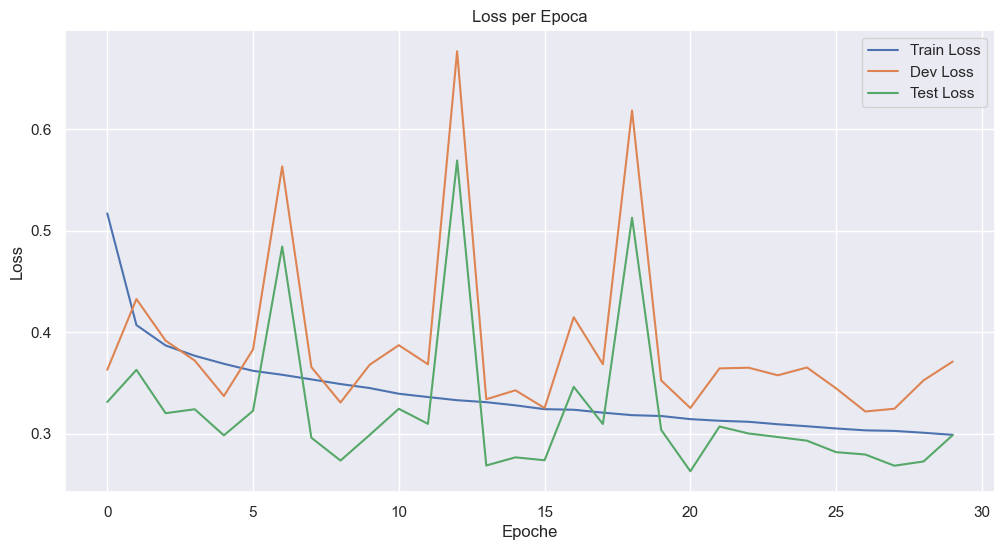

In [ ]:
losses_df = pd.read_csv(os.path.join(processed_data_dir, 'losses_breastcancer.csv'))

title = 'loss_per_epoch'
plt.figure(figsize=(12, 6))
plt.plot(losses_df["train"], label="Train Loss")
plt.plot(losses_df["dev"], label="Dev Loss")
plt.plot(losses_df["test"], label="Test Loss")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.title("Loss per Epoca")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()


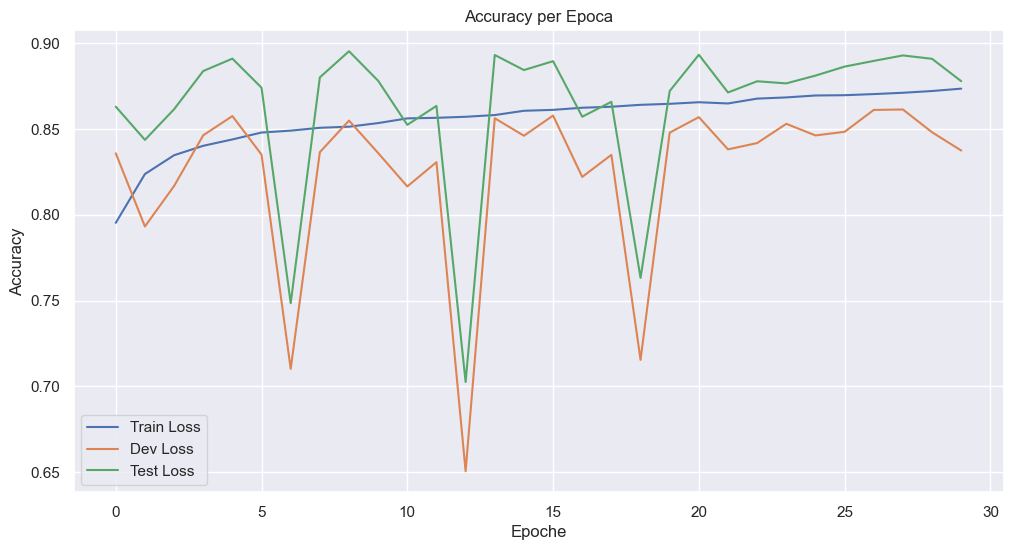

In [ ]:
accuracy_df = pd.read_csv(os.path.join(processed_data_dir, 'accuracy_breastcancer.csv'))

title = 'acc_per_epoch.png'
plt.figure(figsize=(12, 6))
plt.plot(accuracy_df["train"], label="Train Loss")
plt.plot(accuracy_df["dev"], label="Dev Loss")
plt.plot(accuracy_df["test"], label="Test Loss")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoca")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()


### Confusion Matrix

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

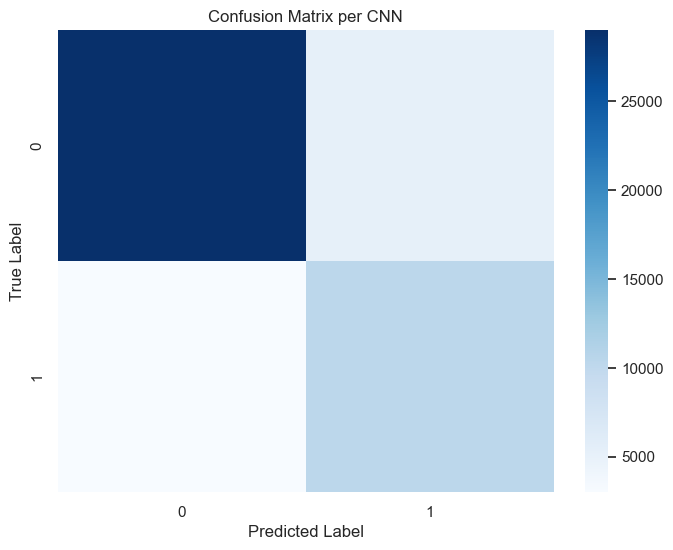

In [ ]:
title = 'CNNconfusionmatrix.png'
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, cmap='Blues', vmin = 3000, vmax = 29000)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix per CNN')
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [ ]:
precision = precision_score(all_labels, all_preds)

recall = recall_score(all_labels, all_preds)

f1 = f1_score(all_labels, all_preds)

print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Precision: 0.6610
Recall: 0.7752
F1 Score: 0.7136
